In [15]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from scipy import stats
import os
from IPython.display import clear_output
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.profiles import DefaultGTiffProfile


name1   = 'co2'
name2   = 'month_ODIAC_down_sampled'
name3   = 'max'

path1   = './'+str(name1)
path2   = './'+str(name2)+'/'+str(name3)

cond    = 20


corr0   = np.load('./Result/'+str(name3)+'/'+str(name2)+'_corr0.npy')

d_shape = corr0.shape
corr_sp = -3000*np.ones((d_shape[0],d_shape[1]),dtype=np.float32)
corr_pe = -3000*np.ones((d_shape[0],d_shape[1]),dtype=np.float32)

saed  = 0
sepid = 0
moh   = 0

path_list1     = sorted([f for f in os.listdir(str(path1)) if f.endswith('.tif')])
ds             = rio.open(str(path1)+'/'+str(path_list1[0]))
kwds           = ds.profile
kwds['nodata'] = -3000.0

for i in range(d_shape[0]):
    for j in range(d_shape[1]):
        a1   = corr0[i,j,0] 
        a2   = corr0[i,j,1]
        ind3 = np.array((a1>-100)&(a2>-100))
        moh  = moh + 1
        if len(ind3[ind3==True]) > cond:
            #a3 = a1[ind3] - np.mean(a1[ind3])
            #a3 = a3 / np.std(a3)
            #a4 = a2[ind3] - np.mean(a2[ind3])
            #a4 = a4 / np.std(a4)
            A    = stats.pearsonr(a1[ind3], a2[ind3])
            B    = stats.spearmanr(a1[ind3], a2[ind3])
            saed = saed+1
            if A[1]<=0.05:
                sepid= sepid +1
                corr_pe[i,j] = A[0]
            if B[1]<= 0.05:
                corr_sp[i,j] = B[0]
print(moh,saed,sepid)                
ds4 = rio.open('./Result/'+str(name3)+'/'+str(name1)+'_'+str(name2)+'_Temporal_correlation_pea.tif', 'w', **kwds)  
ds4.write(corr_pe,1)
ds4.close()
ds5 = rio.open('./Result/'+str(name3)+'/'+str(name1)+'_'+str(name2)+'_Temporal_correlation_spe.tif', 'w', **kwds)  
ds5.write(corr_sp,1)
ds5.close()

1240 638 553


0.6838780187111533 0.014216677288067041


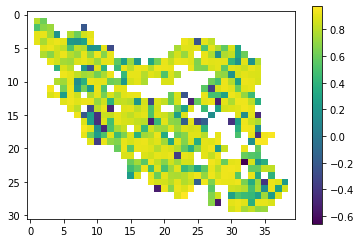

In [16]:
ds = rio.open('./Result/'+str(name3)+'/'+str(name1)+'_'+str(name2)+'_Temporal_correlation_spe.tif')
im = ds.read(1,masked=True)

print(np.mean(im), np.std(im)/np.sqrt(len(im[im>-10])-1))

plt.imshow(im)
plt.colorbar()

In [17]:
# from scipy import ndimage
# im1 = im<-10
# #im[im1] = np.mean(im)

# result      = ndimage.median_filter(im, size=2)
# result[result<-10] = -3000

# dst = rio.open('./test.tif', 'w', **kwds)  
# dst.write(result,1)
# dst.close()
# dsr = rio.open('./test.tif')
# im2  = dsr.read(1,masked=True)


# plt.imshow(im2)
# plt.colorbar()

0.6796645428345389 0.014412578649705972


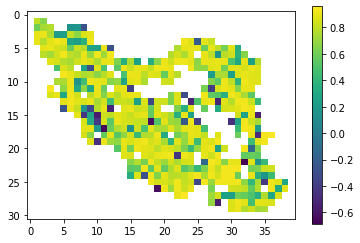

In [18]:
ds = rio.open('./Result/'+str(name3)+'/'+str(name1)+'_'+str(name2)+'_Temporal_correlation_pea.tif')
im = ds.read(1,masked=True)
print(np.mean(im), np.std(im)/np.sqrt(len(im[im>-10])-1))

plt.imshow(im)
plt.colorbar()

In [7]:
# ds = rio.open('./odiac_iran_tif_down_sampled/od_i_2003_04.tif')
# im = ds.read(1,masked=True)
# ds1 = rio.open('./co2/coi_004.tif')
# im1 = ds1.read(1,masked=True)
# print(np.amax(im),np.amin(im),np.mean(im),np.std(im))
# print(np.amax(im1),np.amin(im1),np.mean(im1),np.std(im1))
# #print(im.reshape(im.shape[0]*im.shape[1]))
# ind = np.array((im1>-10)&(im>-10))
# print(stats.pearsonr(im[ind],im1[ind]))

In [26]:
def f3(d,k,tt):
    s    = np.zeros((len(d['i']),2))
    tail = np.percentile(d['r'][(d['s']<= 0.05)],tt)
    
    for i,l in enumerate (d['i']):
        if d['s'][i] <= 0.05 :
            s[i,0] = l - ((l-1)//k)*12
            s[i,1] = (d['r'][i])
        else:
            s[i,0] = -10.
    
    month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Agu','Sep','Oct','Nov','Dec']
    n = k # int(d['i'][-1]/k)
    a = np.zeros((n),dtype=[('year','U10'),('mean','f4'),('std','f4'),('num','i4')])

    for i in range (n):
        NN = len(s[s[:,0]==i+1,1])
        if NN>1:
            a['mean'][i] = np.mean(s[s[:,0]==i+1,1])
            a['std'][i]  = np.std(s[s[:,0]==i+1,1])/np.sqrt(NN-1)
        else:
            a['mean'][i] = np.nan
            a['std'][i]  = np.nan
            
        a['num'][i]  = i
        a['year'][i] = str(month[i]) #str(2003 + (i)//1)
    return a

def f3_1(d,k,tt):
    s = np.zeros((len(d['i']),2))
    tail = np.percentile(d['r'][(d['s']<= 0.05)],tt)
    
    for i,l in enumerate (d['i']):
        if d['s'][i] <= 0.05 and d['r'][i] > tail :
            s[i,0] = l - ((l-1)//k)*12
            s[i,1] = (d['r'][i])
        else:
            s[i,0] = -10.
    
    month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Agu','Sep','Oct','Nov','Dec']
    n = k # int(d['i'][-1]/k)
    a = np.zeros((n),dtype=[('year','U10'),('mean','f4'),('std','f4'),('num','i4')])
    for i in range (n):
        NN = len(s[s[:,0]==i+1,1])
        if NN>1:
            a['mean'][i] = np.mean(s[s[:,0]==i+1,1])
            a['std'][i]  = np.std(s[s[:,0]==i+1,1])/np.sqrt(NN-1)
        else:
            a['mean'][i] = np.nan
            a['std'][i]  = np.nan
            
        a['num'][i]   = i
        a['year'][i] = str(month[i]) #str(2003 + (i)//1)
    return a
       
def f2(d,k,tt=84):
    s    = np.zeros((len(d['i']),2))
    tail = np.percentile(d['r'][(d['s']<=0.05)],tt)
    
    for i,l in enumerate (d['i']):
        if d['s'][i] <= 0.05 and d['r'][i] < tail:
            s[i,0] = (l-1)//k
            s[i,1] = (d['r'][i])
        else:
            s[i,0] = -10.

    n = int(d['i'][-1]/k)
    a = np.zeros((n),dtype=[('year','U10'),('mean','f4'),('std','f4'),('num','i4')])
    for i in range (n):
        NN = len(s[s[:,0]==i,1])
        if NN>1:
            a['mean'][i] = np.mean(s[s[:,0]==i,1])
            a['std'][i]  = np.std(s[s[:,0]==i,1])/np.sqrt(NN-1)
        else:
            a['mean'][i] = np.nan
            a['std'][i]  = np.nan
            
        a['num'][i]  = i
        a['year'][i] = str(2003 + (i)//1)
#         year = 2003 + (i)//2
#         if a['year'][i-1] == str(year):
#             a['year'][i] = ' '
#         else:
#             a['year'][i]  = str(2003 + (i)//2)
    return a


def f2_1(d,k,tt=16):
    s    = np.zeros((len(d['i']),2))
    tail = np.percentile(d['r'][(d['s']<= 0.05)],tt)
    
    for i,l in enumerate (d['i']):
        if d['s'][i] <= 0.05 and d['r'][i] > tail:
            s[i,0] = (l-1)//k
            s[i,1] = (d['r'][i])
        else:
            s[i,0] = -10.

    n = int(d['i'][-1]/k)
    a = np.zeros((n),dtype=[('year','U10'),('mean','f4'),('std','f4'),('num','i4')])
    for i in range (n):
        NN = len(s[s[:,0]==i,1])
        if NN>1:
            a['mean'][i] = np.mean(s[s[:,0]==i,1])
            a['std'][i]  = np.std(s[s[:,0]==i,1])/np.sqrt(NN-1)
        else:
            a['mean'][i] = np.nan
            a['std'][i]  = np.nan
            
        a['num'][i]  = i
        a['year'][i] = str(2003 + (i)//1)
#         year = 2003 + (i)//2
#         if a['year'][i-1] == str(year):
#             a['year'][i] = ' '
#         else:
#             a['year'][i]  = str(2003 + (i)//2)
    return a

        
def f1(d):
    a = np.zeros(len(d[:,0]),dtype=[('i','i4'),('r','f4'),('s','f4')])
    a['i'] = d[:,0]
    a['r'] = d[:,1]
    a['s'] = d[:,2]
    return a

In [52]:
# d_nd = np.loadtxt('./co2_ndvi_iran_tif_down_sampled_Spatial_correlation.txt')
# d    = f1(d_nd)
# d    = f3(d,12)
# print(d)
# fig  = plt.figure(figsize=(10,8))
# my_xticks = d['year']
# # xticks = [' ' for i in range (len(d[0,0]))]
# # xticks2 = [str(i) for i in range(2003,2020)]
# # for i,l in enumerate(xticks2):
# #     my_xticks.append(l)
# #     my_xticks.append(xticks[i])
    
# plt.ylim(-0.75,-0.15)
# plt.xlabel(r'$year$',fontsize=18)
# plt.xticks(d['num'], my_xticks)
# plt.ylabel(r'$\rm Spearman \ Correlation$',fontsize=18)
# plt.errorbar(d['num'],d['mean'],d['std'],fmt='o',label=r'$\rm NDVI$')
# plt.legend(fontsize=18)
# plt.savefig('./Iran_NDVI_Spatial.pdf',bbox_inches='tight')

In [89]:
# d_nd = np.loadtxt('./co2_ndvi_iran_tif_down_sampled_Spatial_correlation.txt')
# d_od = np.loadtxt('./co2_odiac_iran_tif_down_sampled_Spatial_correlation.txt')
# d_pr = np.loadtxt('./co2_per_iran_tif_down_sampled_Spatial_correlation.txt')
# d_lst= np.loadtxt('./co2_lst_iran_tif_down_sampled_Spatial_correlation.txt')
# d_t2 = np.loadtxt('./co2_t2m_iran_tif_down_sampled_Spatial_correlation.txt')

# d    = f1(d_nd)
# d    = f3(d,12,95)
# d2   = f1(d_od)
# d2   = f3(d2,12,95)
# d3   = f1(d_pr)
# d3   = f3(d3,12,95)
# d4   = f1(d_lst)
# d4   = f3_1(d4,12,16)
# d5   = f1(d_t2)
# d5   = f3_1(d5,12,16)

# my_xticks = d['year']

# fig = plt.figure(figsize=(12,8))
# fig.subplots_adjust(hspace=0.08)
# fig.subplots_adjust(wspace=0.05)

# #plt.xticks(d['num'], my_xticks)

# ax0 = fig.add_subplot(221)

# ax0.set_ylabel(r'$\rm Pearson \ Correlation$',fontsize=18)
# ax0.set_ylim(-0.65,-0.05)
# ax0.xaxis.set_tick_params(labelsize=18)
# ax0.yaxis.set_tick_params(labelsize=15)
# ax0.xaxis.set_major_formatter(plt.NullFormatter())
# ax0.errorbar(d['num'],d['mean'],d['std'],fmt='o',label=r'$\rm NDVI$')

# ax1 = fig.add_subplot(222)

# #ax1.set_ylabel(r'$\rm Pearson \ Correlation$',fontsize=18)
# ax1.set_ylim(-0.65,-0.05)
# ax1.xaxis.set_tick_params(labelsize=18)
# ax1.yaxis.set_tick_params(labelsize=15)
# ax1.xaxis.set_major_formatter(plt.NullFormatter())
# ax1.yaxis.set_major_formatter(plt.NullFormatter())
# ax1.errorbar(d3['num'],d3['mean'],d3['std'],fmt='s',label=r'$\rm Precipitation$')


# ax2 = fig.add_subplot(223)


# ax2.set_xticks(my_xticks)
# ax2.set_ylabel(r'$\rm Pearson \ Correlation$',fontsize=18)
# ax2.set_xlabel(r'$\rm Month$',fontsize=18)
# ax2.set_ylim(-0.2,0.65)
# ax2.xaxis.set_tick_params(labelsize=18)
# ax2.yaxis.set_tick_params(labelsize=15)
# #ax2.xaxis.set_major_formatter(plt.NullFormatter())
# #ax2.yaxis.set_major_formatter(plt.NullFormatter())
# ax2.errorbar(d5['num'],d5['mean'],d5['std'],fmt='v',label=r'$\rm Air \ Temperature$')

In [22]:
import matplotlib.gridspec as gridspec
from matplotlib import ticker
from matplotlib.patches import Rectangle
stat = np.loadtxt('./../1.txt')

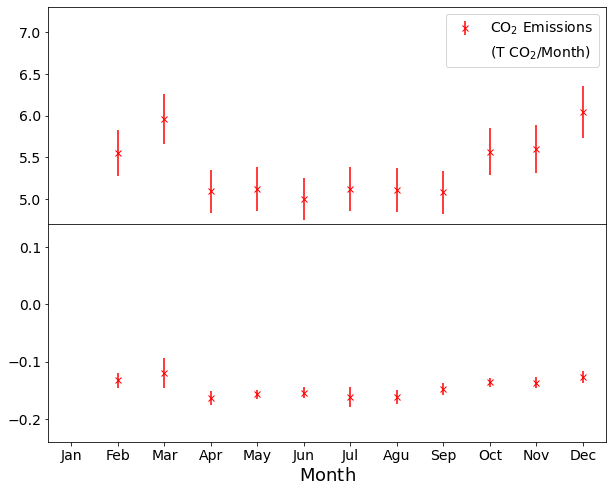

In [7]:
d_od = np.loadtxt('./Result/'+str(name3)+'/co2_odiac_iran_tif_down_sampled_Spatial_correlation.txt')
d2   = f1(d_od)
d2   = f3(d2,12,95)

my_xticks = d2['year'][:]

fig = plt.figure(figsize=(10,8))
gs  = gridspec.GridSpec(10,8)


ax0 = fig.add_subplot(gs[0:5,:])
ax0.set_ylim(4.7,7.3)
ax0.set_xlim(-0.5,11.5)
plot1 = ax0.errorbar(d2['num'][1:],stat[6,1:],stat[7,1:]/np.sqrt(11),fmt='x',color='red')
ax0.xaxis.set_major_formatter(plt.NullFormatter())
ax0.xaxis.set_major_locator(plt.FixedLocator(d2['num'][:]))
ax0.yaxis.set_tick_params(labelsize=(14))
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
ax0.legend([plot1, extra],(r'$\rm CO_2 \ Emissions$', r'$\rm (T \ CO_2/Month) $'), fontsize=14)
#ax0.text(9.2,6.6,r'$\rm [T \ CO_2/Month] $',fontsize=12)
#ax0.yaxis.set_major_locator(plt.FixedLocator(majory))

ax1 = fig.add_subplot(gs[5:,:])
ax1.set_xlim(-0.5,11.5)
ax1.set_ylim(-0.24,0.14)
ax1.set_xlabel(r'$\rm Month$',fontsize=(18))
#ax1.set_ylabel(r'$\rm Pearson \ Correlation$',fontsize=18)
ax1.xaxis.set_major_locator(ticker.FixedLocator(d2['num'][:]))
ax1.xaxis.set_major_formatter(ticker.FixedFormatter(my_xticks))
ax1.xaxis.set_tick_params(labelsize=(14))
ax1.yaxis.set_tick_params(labelsize=(14))
ax1.errorbar(d2['num'][1:],d2['mean'][1:],d2['std'][1:],fmt='x',color='red')#,label=r'$\rm CO_2 \ Emissions$')

fig.subplots_adjust(hspace=0)
plt.savefig('./Iran_CO2_Correlation.tif',bbox_inches='tight')

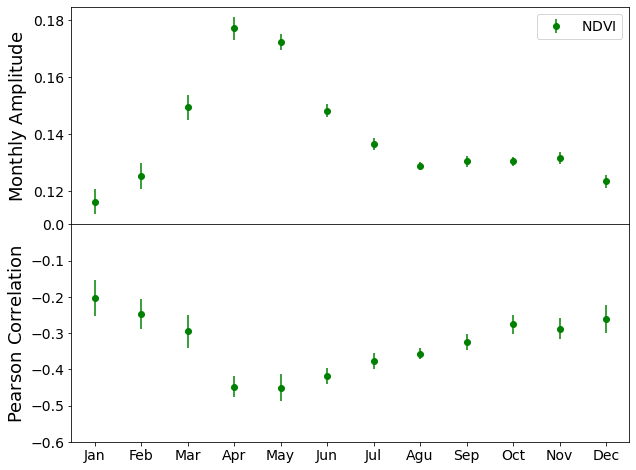

In [31]:
d_nd = np.loadtxt('./Result/'+str(name3)+'/co2_month_NDVI_down_sampled_Spatial_correlation.txt')
d    = f1(d_nd)
d    = f3(d,12,95)

my_xticks = d['year'][:]

fig = plt.figure(figsize=(10,8))
gs  = gridspec.GridSpec(10,8)


ax0 = fig.add_subplot(gs[0:5,:])
#ax0.set_ylim(4.7,7.3)
ax0.set_xlim(-0.5,11.5)
ax0.errorbar(d['num'][:],stat[2,:],stat[3,:]/np.sqrt(11),fmt='o',color='green',label = r'$\rm NDVI$')
ax0.xaxis.set_major_formatter(plt.NullFormatter())
ax0.xaxis.set_major_locator(plt.FixedLocator(d['num'][:]))
ax0.yaxis.set_tick_params(labelsize=(14))
ax0.set_ylabel(r'$\rm Monthly \ Amplitude$',fontsize=18)
#extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
ax0.legend( fontsize=14)
#ax0.text(9.2,6.6,r'$\rm [T \ CO_2/Month] $',fontsize=12)
#ax0.yaxis.set_major_locator(plt.FixedLocator(majory))

ax1 = fig.add_subplot(gs[5:,:])
ax1.set_xlim(-0.5,11.5)
ax1.set_ylim(-0.6,0.0)
#ax1.set_xlabel(r'$\rm Month$',fontsize=(18))
ax1.set_ylabel(r'$\rm Pearson \ Correlation$',fontsize=18)
ax1.xaxis.set_major_locator(ticker.FixedLocator(d['num'][:]))
ax1.xaxis.set_major_formatter(ticker.FixedFormatter(my_xticks))
ax1.xaxis.set_tick_params(labelsize=(14))
ax1.yaxis.set_tick_params(labelsize=(14))
ax1.errorbar(d['num'],d['mean'],d['std'],fmt='o',color='green')

fig.subplots_adjust(hspace=0)

plt.savefig('./Result/Iran_NDVI_Correlation_mean.tif',bbox_inches='tight')

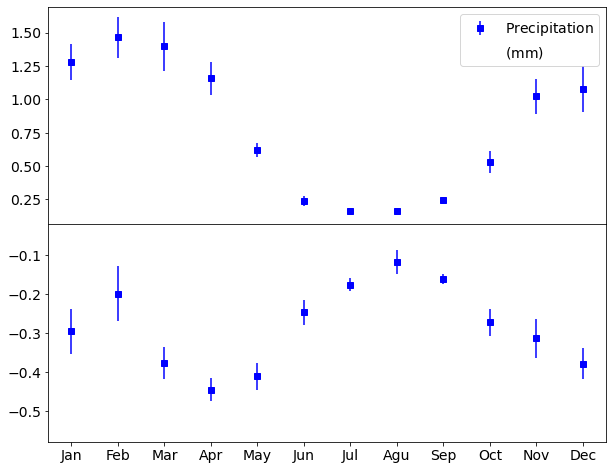

In [22]:
d_pr = np.loadtxt('./co2_per_iran_tif_down_sampled_Spatial_correlation.txt')


d3   = f1(d_pr)
d3   = f3(d3,12,95)

my_xticks = d3['year'][:]

#print(d3)


fig = plt.figure(figsize=(10,8))
gs  = gridspec.GridSpec(10,8)


ax0 = fig.add_subplot(gs[0:5,:])
#ax0.set_ylim(4.7,7.3)
ax0.set_xlim(-0.5,11.5)
plot1 = ax0.errorbar(d3['num'][:],stat[4,:],stat[5,:]/np.sqrt(11),fmt='s',color='blue',label=r'$\rm Precipitation$')
ax0.xaxis.set_major_formatter(plt.NullFormatter())
ax0.xaxis.set_major_locator(plt.FixedLocator(d3['num'][:]))
ax0.yaxis.set_tick_params(labelsize=(14))
#ax0.set_ylabel(r'$\rm Monthly \ Amplitude$',fontsize=18)
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
ax0.legend([plot1, extra],(r'$\rm Precipitation$', r'$\rm (mm) $'), fontsize=14)
#ax0.text(9.2,6.6,r'$\rm [T \ CO_2/Month] $',fontsize=12)
#ax0.yaxis.set_major_locator(plt.FixedLocator(majory))

ax1 = fig.add_subplot(gs[5:,:])
ax1.set_xlim(-0.5,11.5)
ax1.set_ylim(-.58,-0.02)
#ax1.set_xlabel(r'$\rm Month$',fontsize=(18))
#ax1.set_ylabel(r'$\rm Pearson \ Correlation$',fontsize=18)
ax1.xaxis.set_major_locator(ticker.FixedLocator(d3['num'][:]))
ax1.xaxis.set_major_formatter(ticker.FixedFormatter(my_xticks))
ax1.xaxis.set_tick_params(labelsize=(14))
ax1.yaxis.set_tick_params(labelsize=(14))
ax1.errorbar(d3['num'],d3['mean'],d3['std'],fmt='s',color='blue')

fig.subplots_adjust(hspace=0)

#plt.savefig('./Iran_Pre_Correlation.tif',bbox_inches='tight')

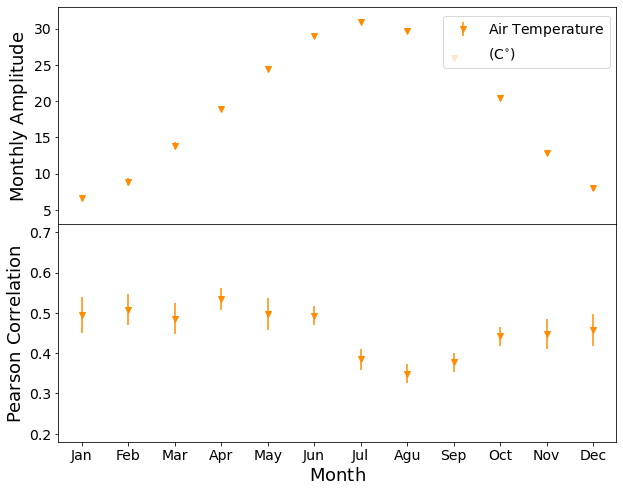

In [23]:
d_t2 = np.loadtxt('./co2_t2m_iran_tif_down_sampled_Spatial_correlation.txt')
d5   = f1(d_t2)
d5   = f3_1(d5,12,16)

my_xticks = d5['year'][:]
#print(d5)

fig = plt.figure(figsize=(10,8))
gs  = gridspec.GridSpec(10,8)


ax0 = fig.add_subplot(gs[0:5,:])
ax0.set_ylim(3,33)
ax0.set_xlim(-0.5,11.5)
plot1 = ax0.errorbar(d5['num'][:],stat[0,:],stat[1,:]/np.sqrt(11),fmt='v',color='darkorange')
ax0.xaxis.set_major_formatter(plt.NullFormatter())
ax0.xaxis.set_major_locator(plt.FixedLocator(d5['num'][:]))
ax0.yaxis.set_tick_params(labelsize=(14))
ax0.set_ylabel(r'$\rm Monthly \ Amplitude$',fontsize=18)
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
ax0.legend([plot1, extra],(r'$\rm Air \ Temperature$', r'$\rm (C^{\circ}) $'),loc=(0.69,0.72), fontsize=14)

#ax0.text(9.2,6.6,r'$\rm [T \ CO_2/Month] $',fontsize=12)
#ax0.yaxis.set_major_locator(plt.FixedLocator(majory))


ax1 = fig.add_subplot(gs[5:,:])
ax1.set_xlim(-0.5,11.5)
ax1.set_ylim(0.18,0.72)
ax1.set_xlabel(r'$\rm Month$',fontsize=(18))
ax1.set_ylabel(r'$\rm Pearson \ Correlation$',fontsize=18)
ax1.xaxis.set_major_locator(ticker.FixedLocator(d5['num'][:]))
ax1.xaxis.set_major_formatter(ticker.FixedFormatter(my_xticks))
ax1.xaxis.set_tick_params(labelsize=(14))
ax1.yaxis.set_tick_params(labelsize=(14))
ax1.errorbar(d5['num'],d5['mean'],d5['std'],fmt='v',color='darkorange',label=r'$\rm Air \ Temperature$')

fig.subplots_adjust(hspace=0)

#plt.savefig('./Iran_T2_Correlation.tif',bbox_inches='tight')

In [109]:



# d_lst= np.loadtxt('./co2_lst_iran_tif_down_sampled_Spatial_correlation.txt')





# d4   = f1(d_lst)
# d4   = f3_1(d4,12,16)


# fig  = plt.figure(figsize=(10,8))
# my_xticks = d['year']
# # xticks = [' ' for i in range (len(d[0,0]))]
# # xticks2 = [str(i) for i in range(2003,2020)]
# # for i,l in enumerate(xticks2):
# #     my_xticks.append(l)
# #     my_xticks.append(xticks[i])
    
# plt.ylim(0.3,0.7)
# plt.xlabel(r'$\rm Month$',fontsize=18)
# plt.xticks(d['num'], my_xticks)
# plt.ylabel(r'$\rm Pearson \ Correlation$',fontsize=18)
# #plt.errorbar(d['num'],d['mean'],d['std'],fmt='o',label=r'$\rm NDVI$')
# #plt.errorbar(d2['num'],d2['mean'],d2['std'],fmt='x',label=r'$\rm CO2 \ Emissions$')
# #plt.errorbar(d3['num'],d3['mean'],d3['std'],fmt='s',label=r'$\rm Precipitation$')
# #plt.errorbar(d4['num'],d4['mean'],d4['std'],fmt='^',label=r'$\rm LST$')
# plt.errorbar(d5['num'],d5['mean'],d5['std'],fmt='v',label=r'$\rm Air \ Temperature$')
# plt.grid(False)
# plt.legend(fontsize=14)
# #plt.savefig('./Iran_Spatial_Correlation.tif',bbox_inches='tight')

In [110]:
# d_nd = np.loadtxt('./co2_ndvi_iran_tif_down_sampled_Spatial_correlation.txt')
# d_od = np.loadtxt('./co2_odiac_iran_tif_down_sampled_Spatial_correlation.txt')
# d_pr = np.loadtxt('./co2_per_iran_tif_down_sampled_Spatial_correlation.txt')
# d_lst= np.loadtxt('./co2_lst_iran_tif_down_sampled_Spatial_correlation.txt')
# d_t2 = np.loadtxt('./co2_t2m_iran_tif_down_sampled_Spatial_correlation.txt')

# d    = f1(d_nd)
# d    = f2(d,12,95)
# d2   = f1(d_od)
# d2   = f2(d2,12,95)
# d3   = f1(d_pr)
# d3   = f2(d3,12,95)
# d4   = f1(d_lst)
# d4   = f2_1(d4,12)
# d5   = f1(d_t2)
# d5   = f2_1(d5,12)

# fig  = plt.figure(figsize=(10,8))
# my_xticks = d['year']
# # xticks = [' ' for i in range (len(d[0,0]))]
# # xticks2 = [str(i) for i in range(2003,2020)]
# # for i,l in enumerate(xticks2):
# #     my_xticks.append(l)
# #     my_xticks.append(xticks[i])
    
# plt.ylim(-0.65,0.7)
# plt.xlabel(r'$\rm Year$',fontsize=18)
# plt.xticks(d['num'], my_xticks)
# plt.ylabel(r'$\rm Spearman \ Correlation$',fontsize=18)
# plt.errorbar(d['num'],d['mean'],d['std'],fmt='o',label=r'$\rm NDVI$')
# plt.errorbar(d2['num'],d2['mean'],d2['std'],fmt='x',label=r'$\rm CO2 \ Emissions$')
# plt.errorbar(d3['num'],d3['mean'],d3['std'],fmt='s',label=r'$\rm Precipitation$')
# #plt.errorbar(d4['num'],d4['mean'],d4['std'],fmt='^',label=r'$\rm LST$')
# plt.errorbar(d5['num'],d5['mean'],d5['std'],fmt='v',label=r'$\rm Air \ Temperature$')
# plt.grid(False)
# plt.legend(fontsize=14)
# #plt.savefig('./Iran_Spatial_Correlation.tif',bbox_inches='tight')

In [186]:
list1 = sorted([f for f in os.listdir('./') if f.endswith('.txt')])
a     = np.zeros((5),dtype=[('m','f4'),('s','f4'),('n','U10')])
for i,l in enumerate (list1):
    d = np.loadtxt(str(l))
    d    = f1(d)
    if 't2m' in str(l) or 'lst' in str(l):
        d   = f2_1(d,12)
    else:
        d    = f2(d,12)
    N = len(d['mean'][~np.isnan(d['mean'])==True])
    
    a['m'][i] = np.nanmean(d['mean'])
    a['s'][i] = (np.nanstd(d['mean'])/(N-1)) + np.nanmax(d['std'])
    a['n'][i] = l
np.savetxt('./mean_correlation.txt',a,fmt='   '.join(['%1.2f']*2+['%s']),header = 'r     error     name')

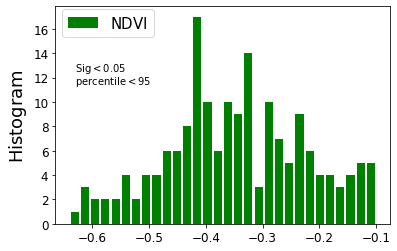

In [9]:
d_nd = np.loadtxt('./co2_ndvi_iran_tif_down_sampled_Spatial_correlation.txt')
#print(d_nd[(d_nd[:,2]<=0.05)&(d_nd[:,1]>=-0.25),0])
#print(np.percentile(d_nd[(d_nd[:,2]<=0.05),1],95))

#mean = np.mean(d_nd[(d_nd[:,2]<=0.05)&(d_nd[:,1]<=tre),1])
#std  = np.std(d_nd[(d_nd[:,2]<=0.05)&(d_nd[:,1]<=tre),1])/np.sqrt(len(d_nd[(d_nd[:,2]<=0.05)&(d_nd[:,1]<=tre),1])+1)

tre = np.percentile(d_nd[(d_nd[:,2]<=0.05),1],95)

#print(d_nd[(d_nd[:,2]>0.05)|(d_nd[:,1]>tre),0])

plt.ylabel(r'$\rm Histogram$',fontsize=18)
#plt.yticks(fontname = "Times New Roman")
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)


#plt.xlabel(r'$\rm Correlation$',fontsize=18)
#plt.xlim(-0.7,0)
plt.hist(d_nd[(d_nd[:,2]<=0.05)&(d_nd[:,1]<=tre),1],bins=30,density=False,histtype='barstacked',rwidth=0.8,
         label=r'$\rm NDVI$',color='g')
plt.text(-0.63,12.5,r'$\rm Sig < 0.05 $',fontsize=10)
plt.text(-0.63,11.5,r'$\rm percentile < 95 $',fontsize=10)
plt.legend(fontsize=15,loc=(0.02,0.86))
#plt.savefig('./Hist_NDVI.tif',bbox_inches='tight')

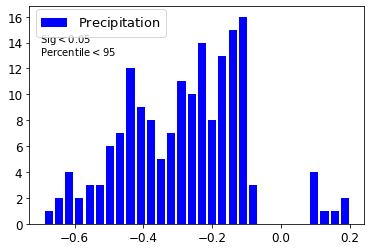

In [24]:
d = np.loadtxt('./co2_per_iran_tif_down_sampled_Spatial_correlation.txt')
#print(d_nd[(d_nd[:,2]<=0.05)&(d_nd[:,1]>=-0.25),0])
#print(np.percentile(d_nd[(d_nd[:,2]<=0.05),1],95))

#mean = np.mean(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])
#std  = np.std(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])/np.sqrt(len(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])+1)

tre  = np.percentile(d[(d[:,2]<=0.05),1],95)

#print(d[(d[:,2]>0.05)|(d[:,1]>tre),0])

#plt.ylabel(r'$\rm Histogram$',fontsize=18)
#plt.xlabel(r'$\rm Correlation$',fontsize=18)
#plt.xlim(-0.8,0.4)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

plt.hist(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1],bins=30,density=False,histtype='barstacked',rwidth=0.8,
         label=r'$\rm Precipitation$',color='b')

plt.text(-0.7,14,r'$\rm Sig < 0.05 $',fontsize=10)
plt.text(-0.7,13,r'$\rm Percentile < 95 $',fontsize=10)
plt.legend(fontsize=13,loc=(0.02,0.86))
#plt.savefig('./Hist_Pre.tif',bbox_inches='tight')

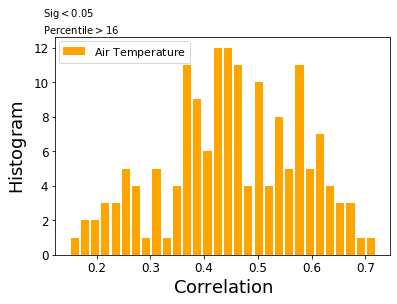

In [25]:
d = np.loadtxt('./co2_t2m_iran_tif_down_sampled_Spatial_correlation.txt')
#print(d_nd[(d_nd[:,2]<=0.05)&(d_nd[:,1]>=-0.25),0])
#print(np.percentile(d_nd[(d_nd[:,2]<=0.05),1],95))

#mean = np.mean(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])
#std  = np.std(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])/np.sqrt(len(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])+1)

tre  = np.percentile(d[(d[:,2]<=0.05),1],16)

#print(d[(d[:,2]>0.05)|(d[:,1]<tre),0])
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

plt.ylabel(r'$\rm Histogram$',fontsize=18)
plt.xlabel(r'$\rm Correlation$',fontsize=18)
plt.hist(d[(d[:,2]<=0.05)&(d[:,1]>=tre),1],bins=30,density=False,histtype='barstacked',rwidth=0.8,
         label=r'$\rm Air \ Temperature$',color='orange')

plt.text(0.1,13.8,r'$\rm Sig < 0.05 $',fontsize=10)
plt.text(0.1,12.8,r'$\rm Percentile > 16 $',fontsize=10)
plt.legend(fontsize=11,loc=(0.01,0.88))
#plt.savefig('./Hist_T2.tif',bbox_inches='tight')

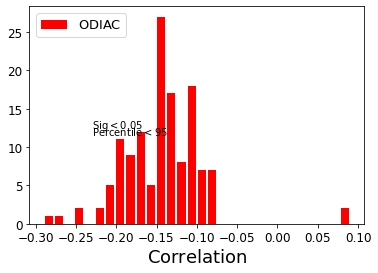

In [8]:
d = np.loadtxt('./co2_odiac_iran_tif_down_sampled_Spatial_correlation.txt')
#print(d_nd[(d_nd[:,2]<=0.05)&(d_nd[:,1]>=-0.25),0])
#print(np.percentile(d_nd[(d_nd[:,2]<=0.05),1],95))

#mean = np.mean(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])
#std  = np.std(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])/np.sqrt(len(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])+1)

tre  = np.percentile(d[(d[:,2]<=0.05),1],95)

#print(d[(d[:,2]>0.05)|(d[:,1]>tre),0])

#plt.ylabel(r'$\rm Histogram$',fontsize=18)
plt.xlabel(r'$\rm Correlation$',fontsize=18)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

#plt.xlim(-0.3,0.3)
plt.hist(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1],bins=30,density=False,histtype='barstacked',rwidth=0.8,
         label=r'$\rm ODIAC$',color='r')

plt.text(-0.23,12.5,r'$\rm Sig < 0.05 $',fontsize=10)
plt.text(-0.23,11.5,r'$\rm Percentile < 95 $',fontsize=10)
plt.legend(fontsize=13,loc=(0.02,0.86))
plt.savefig('./Hist_ODIAC.tif',bbox_inches='tight')

In [ ]:
d = np.loadtxt('./co2_per_iran_tif_down_sampled_Spatial_correlation.txt')
#print(d_nd[(d_nd[:,2]<=0.05)&(d_nd[:,1]>=-0.25),0])
#print(np.percentile(d_nd[(d_nd[:,2]<=0.05),1],95))

#mean = np.mean(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])
#std  = np.std(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])/np.sqrt(len(d[(d[:,2]<=0.05)&(d[:,1]<=tre),1])+1)

tre  = np.percentile(d[(d[:,2]<=0.05),1],95)



plt.ylabel(r'$\rm Histogram$',fontsize=18)
plt.xlabel(r'$\rm Correlation$',fontsize=18)
plt.hist(d[(d[:,2]<=0.05),1],bins=30,density=False,histtype='barstacked',rwidth=0.8,
         label=r'$\rm Precipitation$',color='b')
#plt.text(0.02,15.,r'$\rm R = $'+str(np.round(mean,2)),fontsize=15)
plt.legend(fontsize=13,loc=(0.6,0.8))
plt.savefig('./Hist_Pre.tif',bbox_inches='tight')

In [32]:
# d_lst = np.loadtxt('./co2_lst_iran_tif_down_sampled_Spatial_correlation.txt')

# print(d_lst[(d_lst[:,2]<=0.05)&(d_lst[:,1]<-0.0),0])
# print(np.percentile(d_lst[(d_lst[:,2]<=0.05),1],16))

# plt.plot(d_lst[d_lst[:,2]<=0.05,0],d_lst[d_lst[:,2]<=0.05,1],'o')

In [ ]:
d_pr = np.loadtxt('./co2_per_iran_tif_down_sampled_Spatial_correlation.txt')
print(d_pr[(d_pr[:,2]<=0.05)&(d_pr[:,1]>0.0),0])
print(np.percentile(d_pr[(d_pr[:,2]<=0.05),1],95))


plt.plot(d_pr[d_pr[:,2]<=0.05,0],d_pr[d_pr[:,2]<=0.05,1],'o')

[ 1.  2. 12. 15. 63.]
-0.1


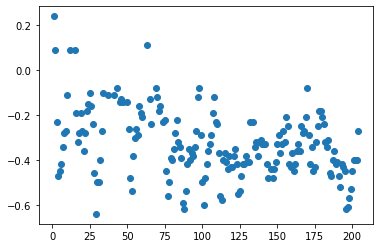

In [52]:
d_pr = np.loadtxt('./co2_ndvi_iran_tif_down_sampled_Spatial_correlation.txt')
print(d_pr[(d_pr[:,2]<=0.05)&(d_pr[:,1]>0.0),0])
print(np.percentile(d_pr[(d_pr[:,2]<=0.05),1],95))


plt.plot(d_pr[d_pr[:,2]<=0.05,0],d_pr[d_pr[:,2]<=0.05,1],'o')

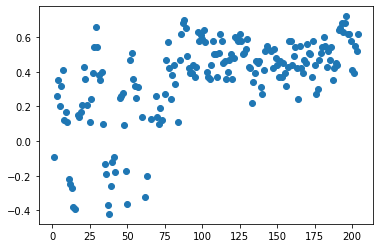

In [50]:
d_t2 = np.loadtxt('./co2_t2m_iran_tif_down_sampled_Spatial_correlation.txt')
plt.plot(d_t2[d_t2[:,2]<=0.05,0],d_t2[d_t2[:,2]<=0.05,1],'o')

[  1.   2.   7.  10.  12.  14.  15.  17.  23.  34.  48.  49.  50.  63.
  66.  83.  91.  93. 107. 122. 135. 142. 147. 157. 169. 170. 171. 178.
 181. 189. 199. 200.]
0.09


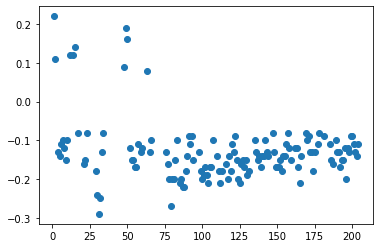

In [51]:
d_od = np.loadtxt('./co2_odiac_iran_tif_down_sampled_Spatial_correlation.txt')
print(d_od[(d_od[:,2]<=0.05)&(d_od[:,1]>=-0.1),0])
print(np.percentile(d_od[(d_od[:,2]<=0.05),1],95))


plt.plot(d_od[d_od[:,2]<=0.05,0],d_od[d_od[:,2]<=0.05,1],'o')

In [38]:
# a = np.union1d(d_pr[(d_pr[:,2]<=0.05)&(d_pr[:,1]>0.0),0], d_od[(d_od[:,2]<=0.05)&(d_od[:,1]>=-0.1),0])
# b = np.union1d(d_nd[(d_nd[:,2]<=0.05)&(d_nd[:,1]>=-0.15),0],a)


#  c = [9.  10.  11.  12.  13.  15.  16.  22.  23.  29.  32.  33.  34.  35.
#   36.  37.  38.  39.  43.  50.  51.  52.  55.  57.  58.  59.  69.  70.
#   74.  75.  81.  82.  83.  84.]
    
# print(np.intersect1d(b,c))
# #print(d_pr[(d_pr[:,2]<=0.05)&(d_pr[:,1]>0.0),0])
# #print(d_od[(d_od[:,2]<=0.05)&(d_od[:,1]>=-0.1),0])
# #print(d_nd[(d_nd[:,2]<=0.05)&(d_nd[:,1]>=-0.15),0])

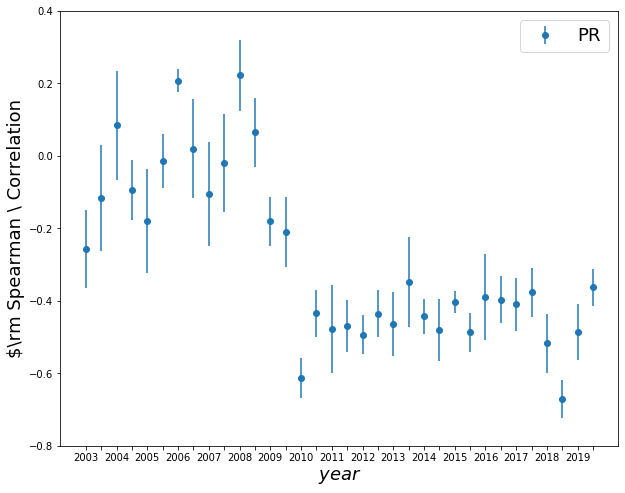

In [15]:
d_pr = np.loadtxt('./co2_per_iran_tif_down_sampled_Spatial_correlation.txt')
d = f1(d_pr)
d = f2(d,6)
fig = plt.figure(figsize=(10,8))
my_xticks = []
xticks = [' ' for i in range (len(d[0,0]))]
xticks2 = [str(i) for i in range(2003,2020)]
for i,l in enumerate(xticks2):
    my_xticks.append(l)
    my_xticks.append(xticks[i])
    
plt.ylim(-0.8,0.4)
plt.xlabel(r'$year$',fontsize=18)
plt.xticks(d[0,0], my_xticks)
plt.ylabel(r'$\rm Spearman \ Correlation',fontsize=18)
plt.errorbar(d[0,0],d[0,1],d[0,2],fmt='o',label=r'$\rm PR$')
plt.legend(fontsize=18)
plt.savefig('./Iran_PR_Spatial.pdf',bbox_inches='tight')

[('2003', -0.25666666, 0.09877022,  0)
 ('2004', -0.305     , 0.045     ,  1)
 ('2005', -0.26      , 0.0454606 ,  2)
 ('2006', -0.25      , 0.06      ,  3)
 ('2007', -0.275     , 0.005     ,  4)
 ('2008', -0.275     , 0.05500001,  5)
 ('2009', -0.2325    , 0.05760859,  6)
 ('2010', -0.34166667, 0.09762456,  7)
 ('2011', -0.35272726, 0.0990033 ,  8)
 ('2012', -0.315     , 0.07433034,  9)
 ('2013', -0.35416666, 0.07330965, 10)
 ('2014', -0.31583333, 0.0588017 , 11)
 ('2015', -0.35454544, 0.02995864, 12)
 ('2016', -0.28727272, 0.07758759, 13)
 ('2017', -0.30363637, 0.08336914, 14)
 ('2018', -0.32909092, 0.06828477, 15)]


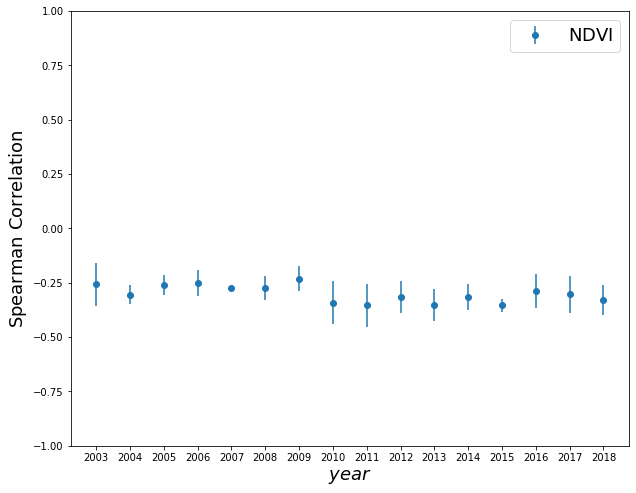

In [24]:
d_od = np.loadtxt('./co2_odiac_iran_tif_down_sampled_Spatial_correlation.txt')
d = f1(d_od)
d = f2(d,12)


print(d)
fig  = plt.figure(figsize=(10,8))
my_xticks = d['year']
# xticks = [' ' for i in range (len(d[0,0]))]
# xticks2 = [str(i) for i in range(2003,2020)]
# for i,l in enumerate(xticks2):
#     my_xticks.append(l)
#     my_xticks.append(xticks[i])
    
plt.ylim(-1,1)
plt.xlabel(r'$year$',fontsize=18)
plt.xticks(d['num'], my_xticks)
plt.ylabel(r'$\rm Spearman \ Correlation$',fontsize=18)
plt.errorbar(d['num'],d['mean'],d['std'],fmt='o',label=r'$\rm NDVI$')
plt.legend(fontsize=18)

#plt.savefig('./Iran_ODIAC_Spatial.pdf',bbox_inches='tight')

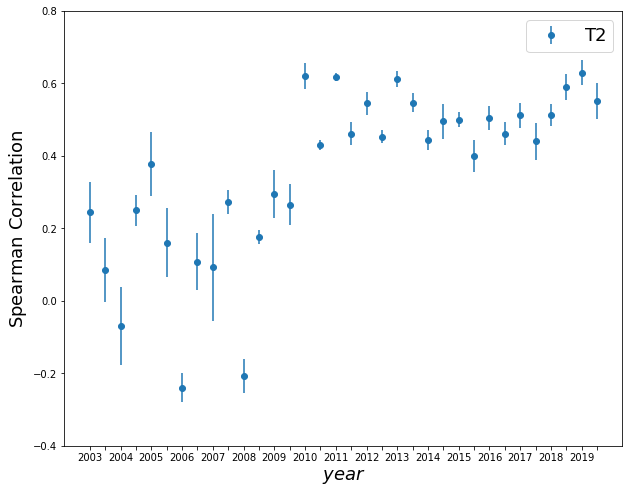

In [21]:
d_t2 = np.loadtxt('./co2_t2m_iran_tif_Spatial_correlation.txt')

d = f1(d_t2)
d = f2(d,6)
fig = plt.figure(figsize=(10,8))
my_xticks = []
xticks = [' ' for i in range (len(d[0,0]))]
xticks2 = [str(i) for i in range(2003,2020)]
for i,l in enumerate(xticks2):
    my_xticks.append(l)
    my_xticks.append(xticks[i])
    
plt.ylim(-0.4,0.8)
plt.xlabel(r'$year$',fontsize=18)
plt.xticks(d[0,0], my_xticks)
plt.ylabel(r'$\rm Spearman \ Correlation$',fontsize=18)
plt.errorbar(d[0,0],d[0,1],d[0,2],fmt='o',label=r'$\rm T2$')
plt.legend(fontsize=18)
plt.savefig('./Iran_T2_Spatial.pdf',bbox_inches='tight')

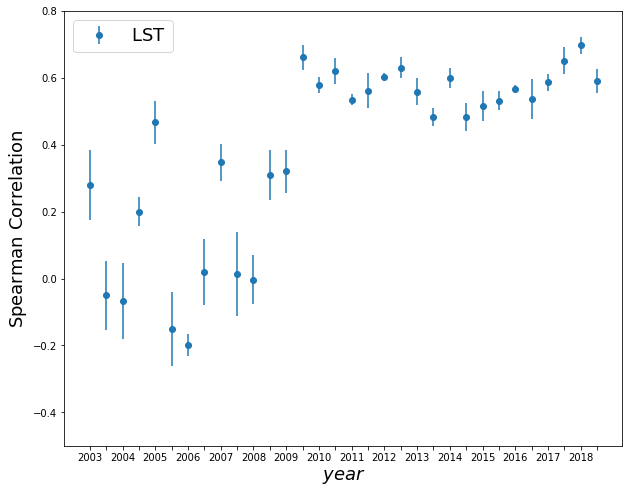

In [28]:
d_lst= np.loadtxt('./co2_lst_iran_tif_down_sampled_Spatial_correlation.txt')
d = f1(d_lst)
d = f2(d,6)
fig = plt.figure(figsize=(10,8))
my_xticks = []
xticks = [' ' for i in range (len(d[0,0]))]
xticks2 = [str(i) for i in range(2003,2020)]
for i,l in enumerate(xticks2):
    my_xticks.append(l)
    my_xticks.append(xticks[i])
   
plt.ylim(-0.5,0.8)
plt.xlabel(r'$year$',fontsize=18)
plt.xticks(d[0,0], my_xticks)
plt.ylabel(r'$\rm Spearman \ Correlation$',fontsize=18)
plt.errorbar(d[0,0],d[0,1],d[0,2],fmt='o',label=r'$\rm LST$')
plt.legend(fontsize=18)
plt.savefig('./Iran_LST_Spatial.pdf',bbox_inches='tight')

In [36]:
# # transforming the number to month and year
# d_nd = np.loadtxt('./co2_ndvi_iran_tif_down_sampled_Spatial_correlation.txt')
# d    = f1(d_nd)
# k    = 6
# n    = int(d['i'][-1]/k)
# for i in range (n):
#     print(2003+i//2)
# # for i in (d['i']):
# #     k = i//13
# #     print((i-1)//6,np.mod(i-1,6))

16.833333333333332